# Place Cell Formation
Following Solstad et al.paper

In [1]:
import vco
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Initializing VCO matrix
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol
phz_noise = 0

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

In [3]:
def plot_many(things_to_plot):
    number = things_to_plot.shape[2]
    n_rc = int(np.ceil(np.sqrt(number)))
    n_plots = n_rc**2
    if n_plots > number:
        n_plots = number
    
    fig, axes = plt.subplots(nrows=n_rc, ncols=n_rc, sharex=True, sharey=True, figsize=(10,10))
    axes_list = [item for sublist in axes for item in sublist]

    for idx in range(n_plots):
        ax = axes_list.pop(0)
        ax.imshow(things_to_plot[:,:,idx],cmap='jet',extent=(-size,size,-size,size))
        ax.set_title(idx)
        ax.tick_params(
            which='both',
            bottom='off',
            left='off',
            right='off',
            top='off'
        )
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    for ax in axes_list:
        ax.remove()

    plt.tight_layout()

The goal here is to include only grid cells of particular spatial period, sampled uniformly across rotation and along a PDF for spatial period. Spatial period is determined by row. Spatial phase is determined by.... and rotation is determined by ...

In [4]:
def solstad_weights(lambda_low, lambda_up, sigma, N):
    lam = np.arange(1,10001,1)
    dist_constants = (2 * np.pi * sigma**2) * ((2*np.pi)/N) * np.log(lambda_up/lambda_low)
    dist = dist_constants * np.exp((-4.0/3)* np.pi**2 * sigma**2 / lam**2) / lam**2
    pdf = dist/np.sum(dist)
    

In [5]:
full_matrix = np.full([6,12,6*4*12**3], np.nan)
jdx = 0
for row in range(6):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    full_matrix[row,firstcol,  jdx] = cell1
                    full_matrix[row,firstcol+4,jdx] = cell2
                    full_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1

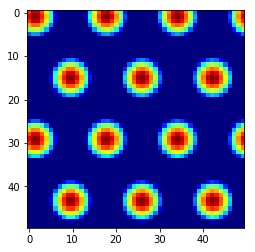

In [6]:
plt.imshow(vco.theta_to_hcn(VCOmat,full_matrix[:,:,28005],5)[0],cmap='jet')

In [7]:
def almeida_weights(size):
    A, B = 100.7, 0.02
    sigma = np.array([0.02, 0.018, 0.15])
    s = np.arange(0,0.2,0.0001)
    dist = A * (1 - np.exp(- s/sigma[0])) * (np.exp(- s/sigma[1]) + B * np.exp(- s/sigma[2]))
    pdf = dist/np.sum(dist)
    syn_diam = nprd.choice(s,size=size,p=pdf)
    weights = (syn_diam/0.2)*(syn_diam/(syn_diam+0.0314))
    return weights

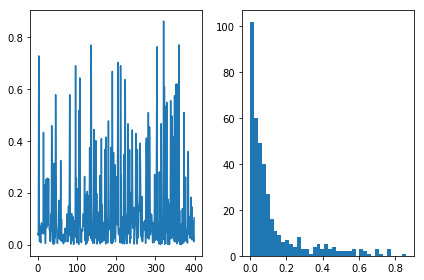

In [8]:
weights = almeida_weights(400)
plt.subplot(121)
plt.plot(weights)
plt.subplot(122)
plt.hist(weights,bins=40)
plt.tight_layout()

In [9]:
full_matrix = np.full([6,12,6*4*12**3], np.nan)
jdx = 0
for row in range(6):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    full_matrix[row,firstcol,  jdx] = cell1
                    full_matrix[row,firstcol+4,jdx] = cell2
                    full_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1

In [10]:
grid_weights = full_matrix

In [11]:
size = 5
num_grids = grid_weights.shape[2]

grid_outputs = np.zeros([10*size, 10*size, num_grids])
for gc in range(num_grids):
    grid_outputs[:,:,gc], _ = vco.theta_to_hcn(VCOmat,grid_weights[:,:,gc],size)

In [12]:
index = 22025

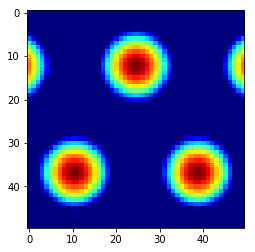

In [13]:
plt.imshow(grid_outputs[:,:,index],cmap='jet')

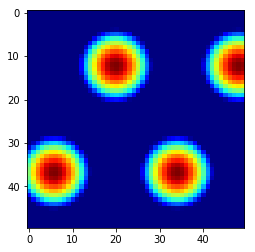

In [14]:
plt.imshow(grid_outputs[:,:,index-(4*6*12)],cmap='jet')

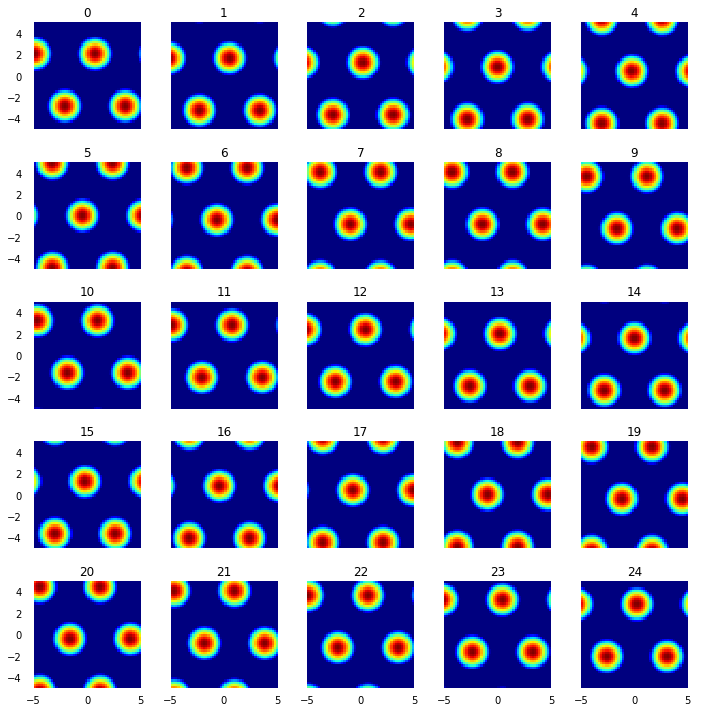

In [15]:
plot_many(grid_outputs[:,:,22000:22025])

In [13]:
num_places = 100
num_gc = 1200
thresh = 0.8

place_cells = np.zeros([10*size, 10*size, num_places])
weights = almeida_weights(num_gc)

for pc in range(num_places):
    idx = np.arange(num_grids)
    nprd.shuffle(idx)
    idx = idx[0:num_gc]
    for i, gc_ind in enumerate(idx):
        place_cells[:,:,pc] = place_cells[:,:,pc] + weights[i] * grid_outputs[:,:,gc_ind]
    out_max = np.max(place_cells[:,:,pc])
    out_thresh = place_cells[:,:,pc] - thresh*out_max
    out_thresh[out_thresh<0] = 0
    out_max  = np.max(out_thresh)
    
    place_cells[:,:,pc] = out_thresh/out_max
    

## Creating grid cells according to Solstad's equations

In [384]:
def psi(lam, theta, r, r_0):
    k = 4*np.pi / (np.sqrt(3) * lam)

    k1 = (k/np.sqrt(2)) * np.array([np.cos(theta + np.pi/12)+np.sin(theta + np.pi/12), np.cos(theta + np.pi/12) - np.sin(theta + np.pi/12)])
    k2 = (k/np.sqrt(2)) * np.array([np.cos(theta + 5*np.pi/12)+np.sin(theta + 5*np.pi/12), np.cos(theta + 5*np.pi/12) - np.sin(theta + 5*np.pi/12)])
    k3 = (k/np.sqrt(2)) * np.array([np.cos(theta + 3*np.pi/4)+np.sin(theta + 3*np.pi/4), np.cos(theta + 3*np.pi/4) - np.sin(theta + 3*np.pi/4)])
    
    psi_w = (np.cos(np.dot(k1, (r - r_0).T)) + np.cos(np.dot(k2,(r - r_0).T)) + np.cos(np.dot(k3,(r - r_0).T)))/3.0    
    return psi_w

In [369]:
size = 5
ss = np.linspace(-size,size,10*size)
xx, yy = np.meshgrid(ss,ss,sparse=True)

In [307]:
path = vco.randwalk(10,100000,5)

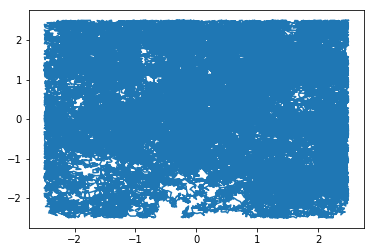

In [308]:
plt.plot(path[:,0],path[:,1])

In [309]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection

In [385]:
psi_w = psi(2,0,path,np.array([0,0]))

In [392]:
psi_w_2 = psi(2,0,path,np.array([2.2,0]))

(-2.5, 2.5)

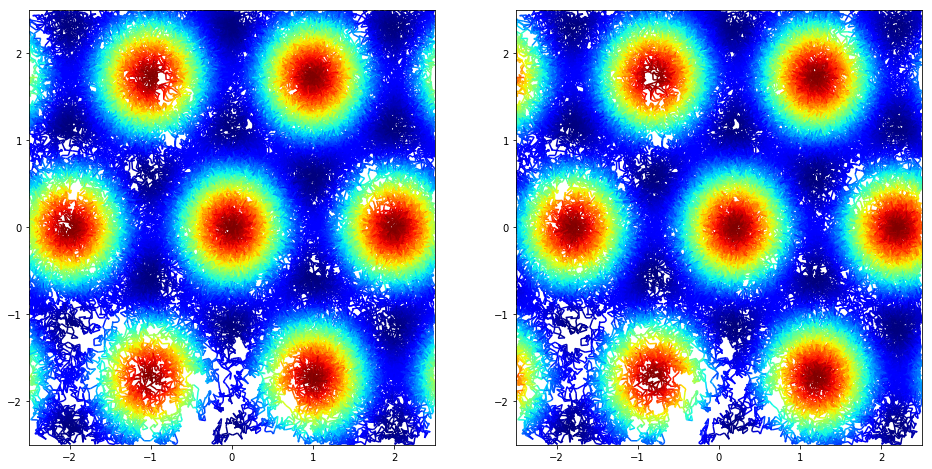

In [393]:
x = path[:,0]
y = path[:,1]

# set up a list of (x,y) points
points = np.array([x,y]).transpose().reshape(-1,1,2)
# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
# make the collection of segments
lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
lc.set_array(psi_w) # color the segments by our parameter

# plot the collection
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().add_collection(lc) # add the collection to the plot
plt.xlim(-2.5, 2.5) # line collections don't auto-scale the plot
plt.ylim(-2.5, 2.5)


plt.subplot(122)
lc2 = LineCollection(segs, cmap=plt.get_cmap('jet'))
lc2.set_array(psi_w_2) # color the segments by our parameter
plt.gca().add_collection(lc2) # add the collection to the plot
plt.xlim(-2.5, 2.5) # line collections don't auto-scale the plot
plt.ylim(-2.5, 2.5)

In [395]:
def plot_solstad(path, func, arena=(5,5)):
    x   = path[:,0]
    y   = path[:,1]

    # set up a list of (x,y) points
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(func) # color the segments by our parameter

    # plot the collection
    plt.figure()
    plt.gca().add_collection(lc) # add the collection to the plot
    plt.xlim(-arena[0], arena[0]) # line collections don't auto-scale the plot
    plt.ylim(-arena[1], arena[1])

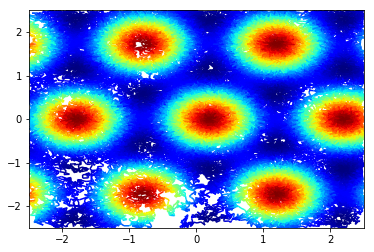

In [397]:
plot_solstad(path,psi_w_2,(2.5,2.5))